# Conversational Threads

Many LLM applications have a chatbot-like interface in which the user and the LLM application engage in a multi-turn conversation. In order to track these conversations, you can use the Threads feature in LangSmith.

This is relevant to our RAG application, which should maintain context from prior conversations with users.

### Setup

In [70]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

### Group traces into threads


A Thread is a sequence of traces representing a single conversation. Each response is represented as its own trace, but these traces are linked together by being part of the same thread.

To associate traces together, you need to pass in a special metadata key where the value is the unique identifier for that thread.

The key value is the unique identifier for that conversation. The key name should be one of:

- session_id
- thread_id
- conversation_id.

The value should be a UUID.

In [71]:
import uuid
thread_id = uuid.uuid4()

In [72]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


### Now let's run our application twice with this thread_id

In [73]:
question = "How do I add metadata to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

To add metadata to a trace in LangSmith, you need to include a dictionary of key-value pairs when creating the trace. This metadata can store additional information about the trace, such as the environment or user details. Ensure that the same metadata is also attached to the corresponding run for better tracking.


In [74]:
question = "How can I add tags to a Trace?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

You can add tags to a trace in LangSmith by sending arbitrary metadata and tags along with the trace. Tags are strings used to categorize or label the trace, while metadata is a dictionary of key-value pairs for additional information. For detailed instructions, refer to the documentation on adding metadata and tags to traces.


### My Inference :  We have formed a thread, which makes up a chat interface, where users questions and the responses to it will be shown.each input from the user forms a new trace and all these traces are bundled up together in a thread which gives us that chat interface type of look.
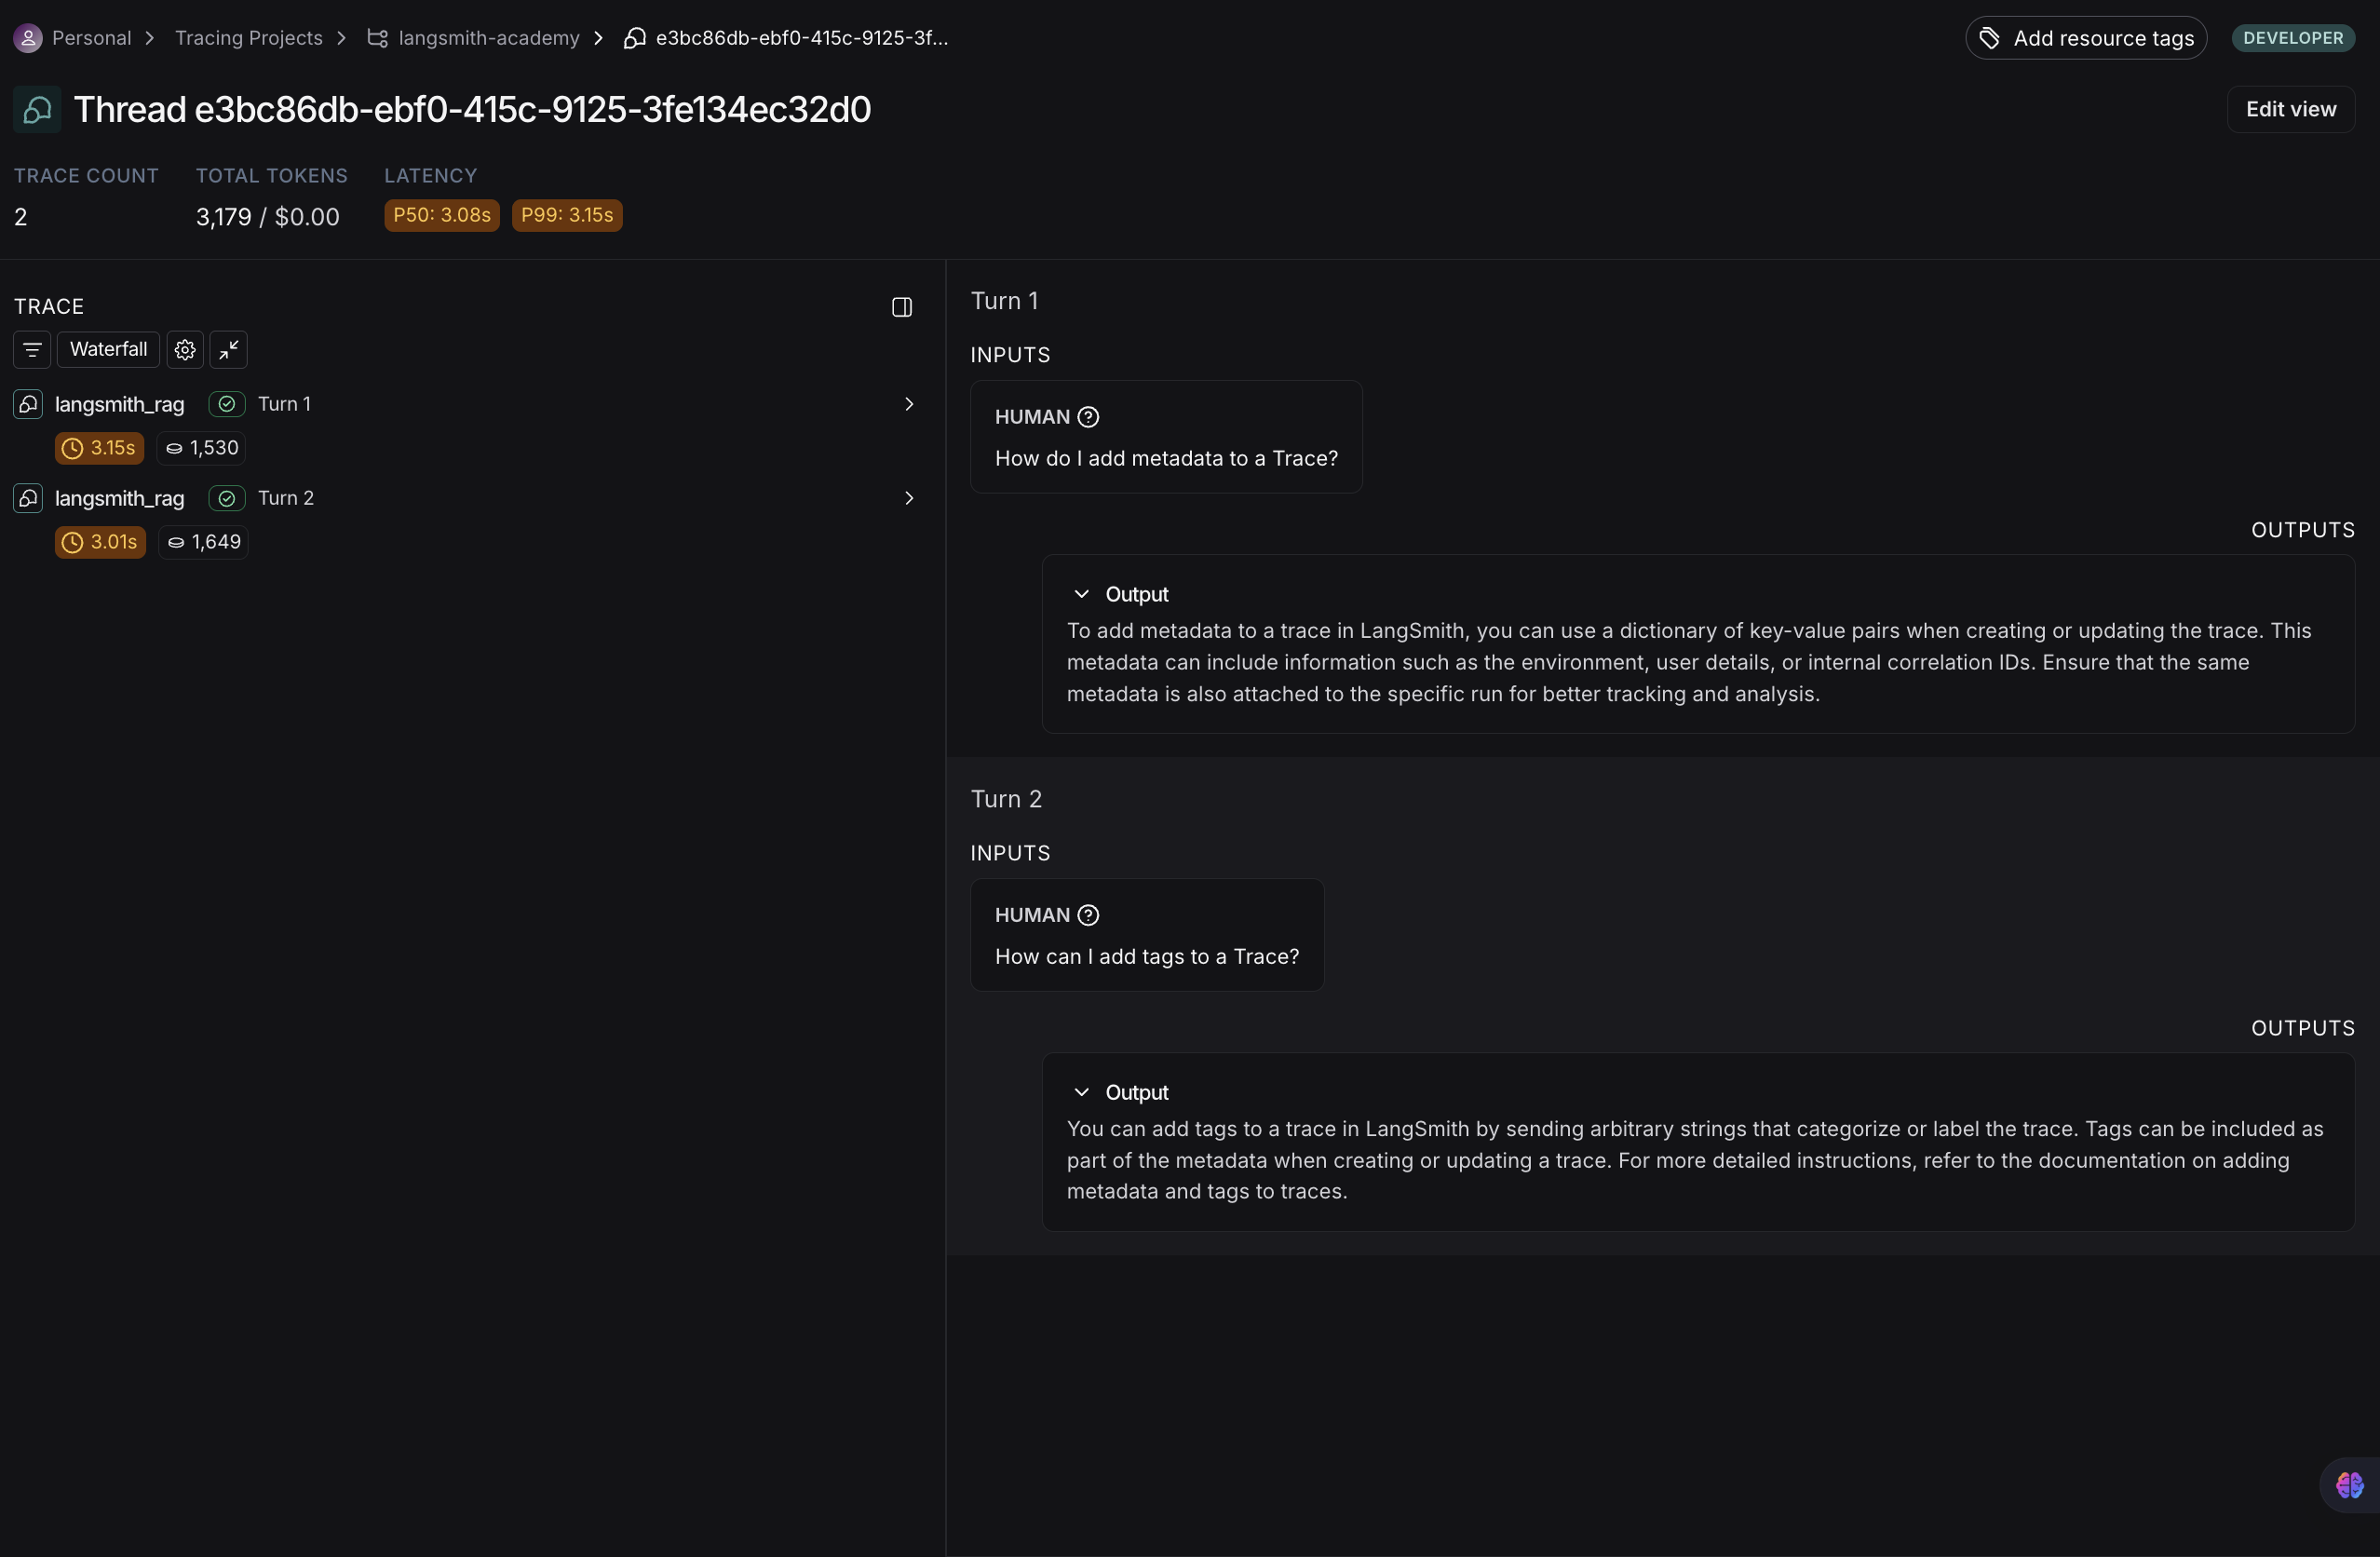

## my questions with a new thread id :

In [75]:
threadd_id = uuid.uuid4()
question = "What is Langchain and Langsmith"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

LangChain is a framework designed for building applications that utilize large language models (LLMs), providing tools for retrieval, agents, and evaluation. LangSmith, on the other hand, is a platform for LLM observability and evaluation, allowing users to monitor and assess their applications' performance. Both tools are framework agnostic and can be used independently or together.


In [76]:
question = "how does langhchain help us ?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

LangChain helps by providing tools and frameworks for building applications that utilize language models effectively. It offers off-the-shelf evaluators, APIs, and SDKs for various programming languages, making it easier to integrate language processing capabilities into your projects. Additionally, it ensures data privacy by not storing sensitive information or sharing it with third parties.


In [77]:
question = "List everything that Langsmith can do, in a bulleted form "
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

- Provides a frontend and backend for user interaction and processing.
- Offers a platform backend for managing services.
- Includes a Playground for testing and experimentation.
- Manages a queue for task handling.
- Supports Arbitrary Code Execution (ACE) backend.
- Utilizes databases like ClickHouse and PostgreSQL for data storage.
- Employs Redis for caching and fast data retrieval.
- Allows for optional Blob storage for additional data management.
- Enables the definition of transformations to enhance datasets from traces.


In [78]:
question = "Now list 8 things langchain can do in a bulleted list "
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

- 1-Click Deploy for easy service deployment
- Horizontally-scalable service for production-sized deployments
- Assistants API with 30+ API endpoints including state and memory
- Cron scheduling for automated tasks
- Authentication & authorization for LangGraph APIs
- Support for Cloud, Hybrid, or Self-Hosted deployment types
- Role-Based Access Control for organization roles (User and Admin)
- Community support via Slack and email support options


In [79]:
question = "Can u explain the content of ur previous message again"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": threadd_id}})
print(ai_answer)

In my previous message, I expressed understanding of your frustration regarding the issue with your vehicle and apologized for the inconvenience. I also mentioned that I would review your case to expedite your refund and appreciated your patience while I worked on resolving the matter. If you have any specific details to share, please let me know so I can assist you further.


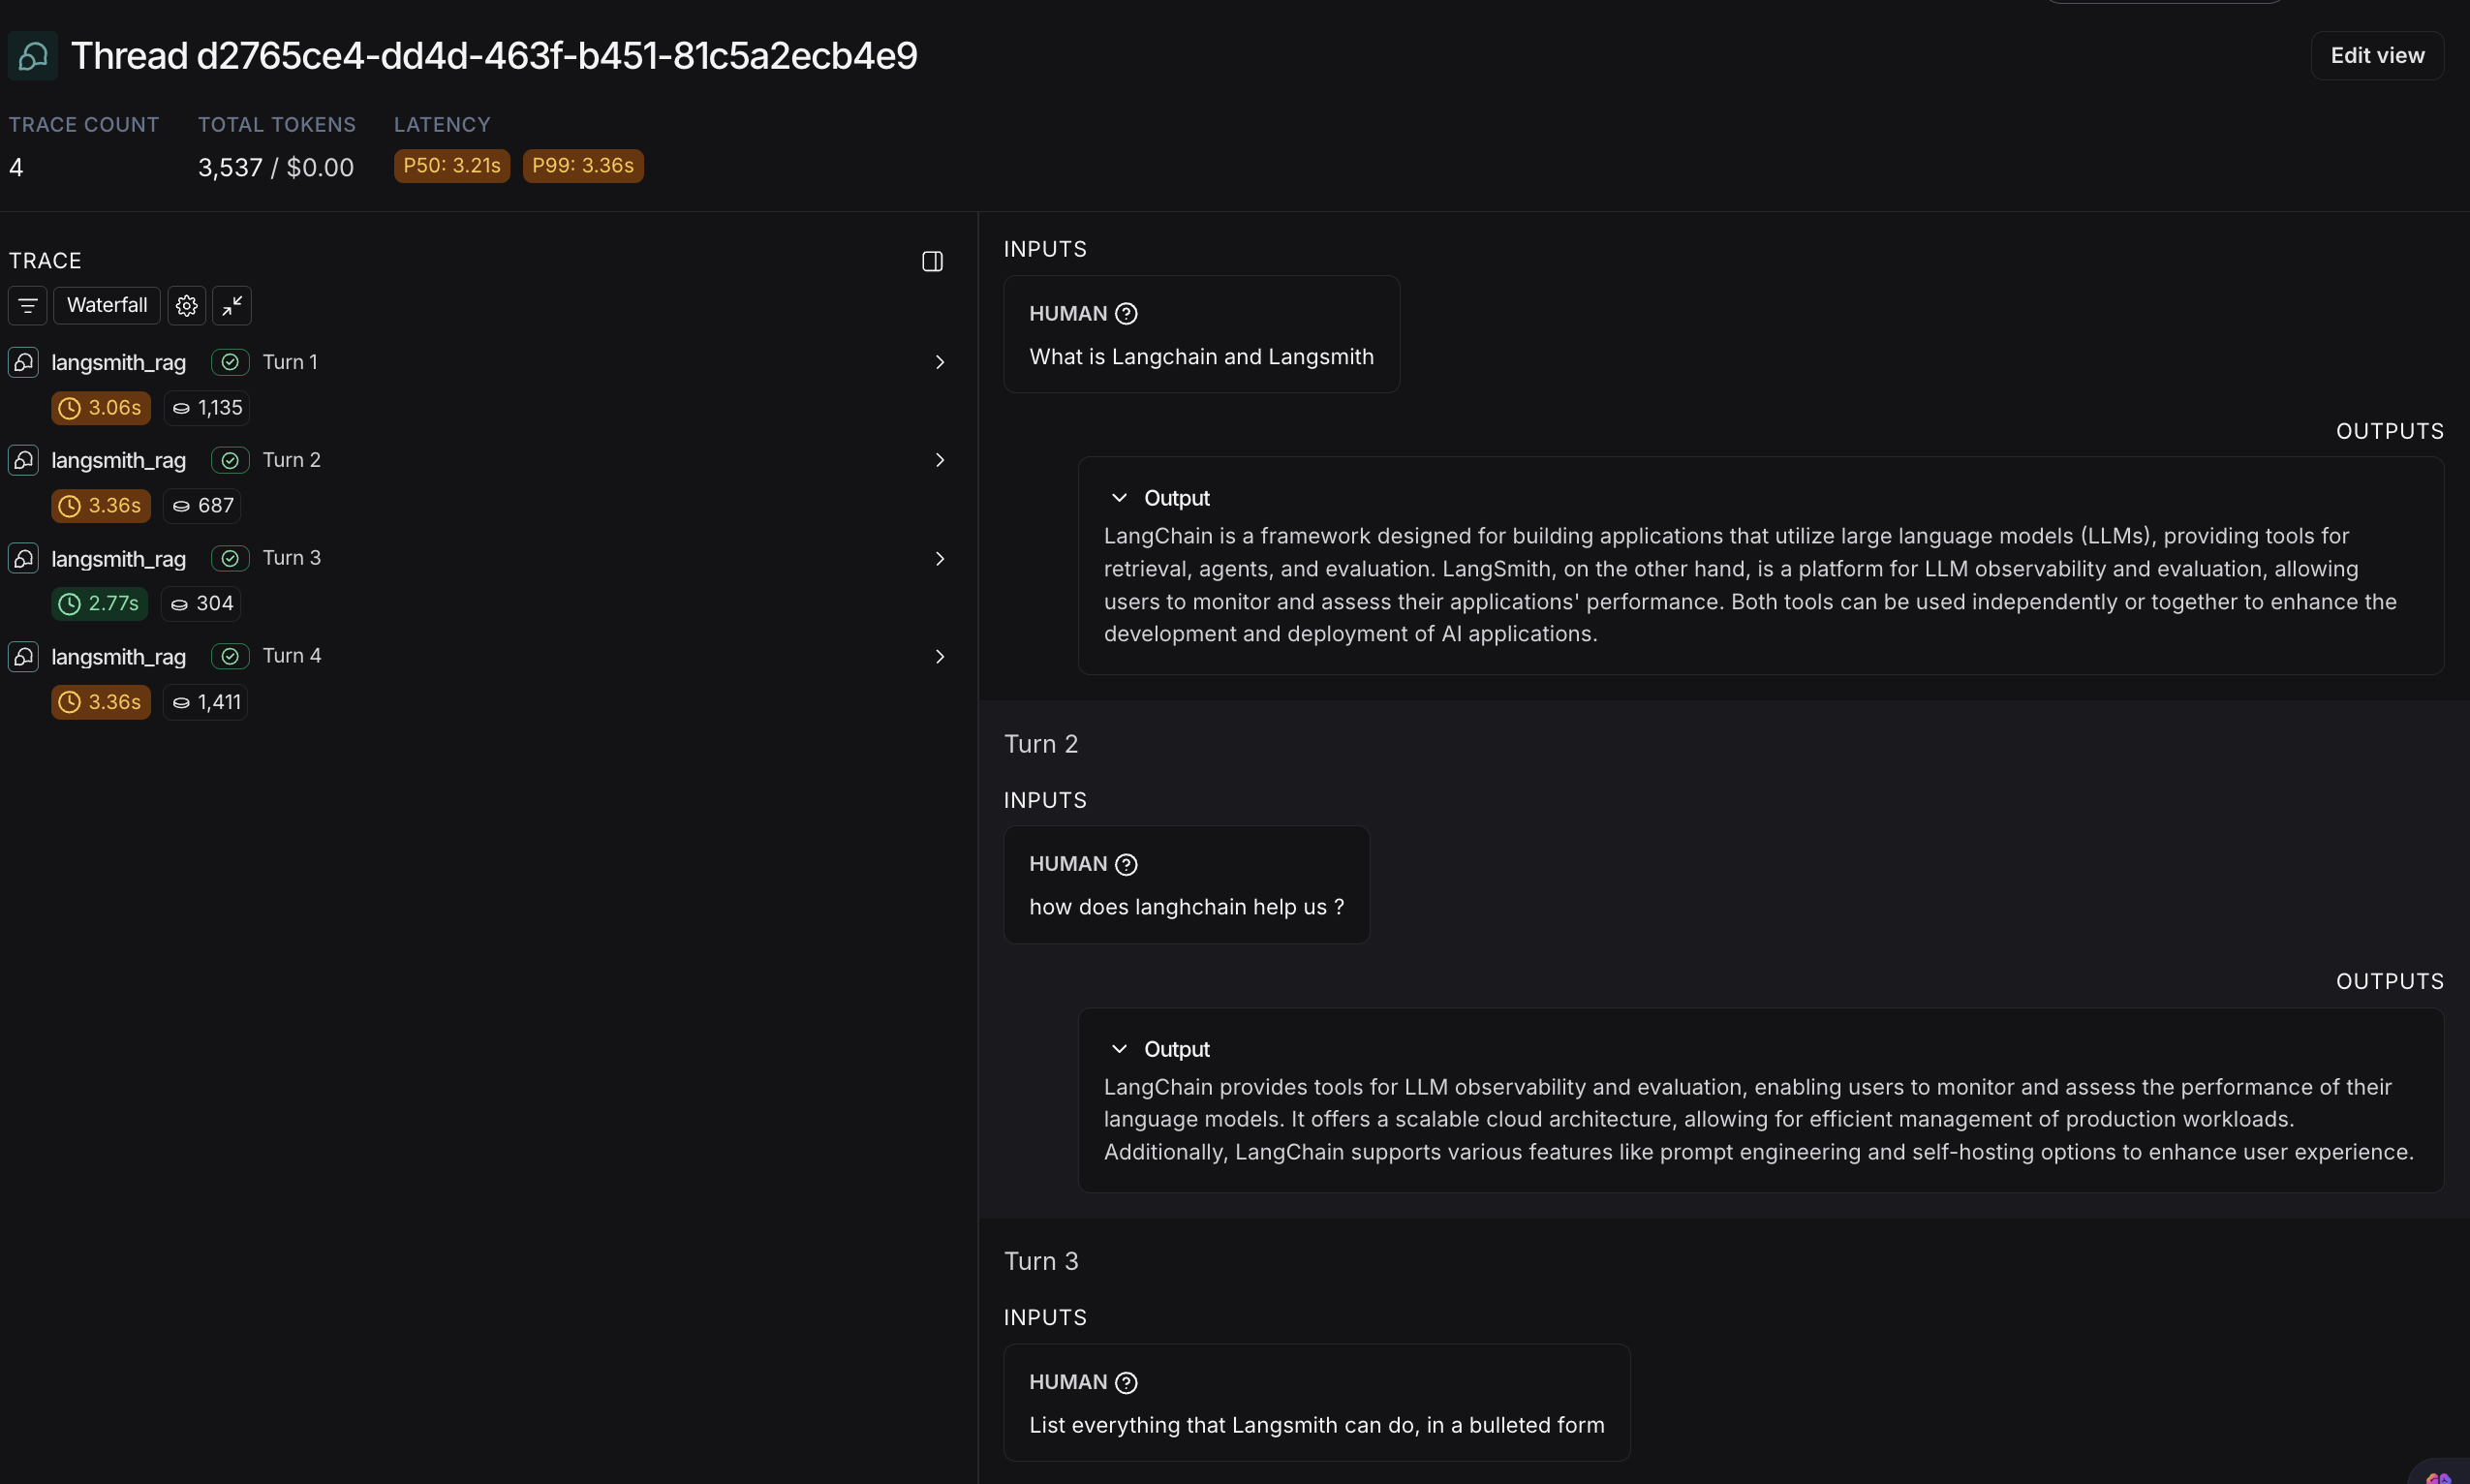



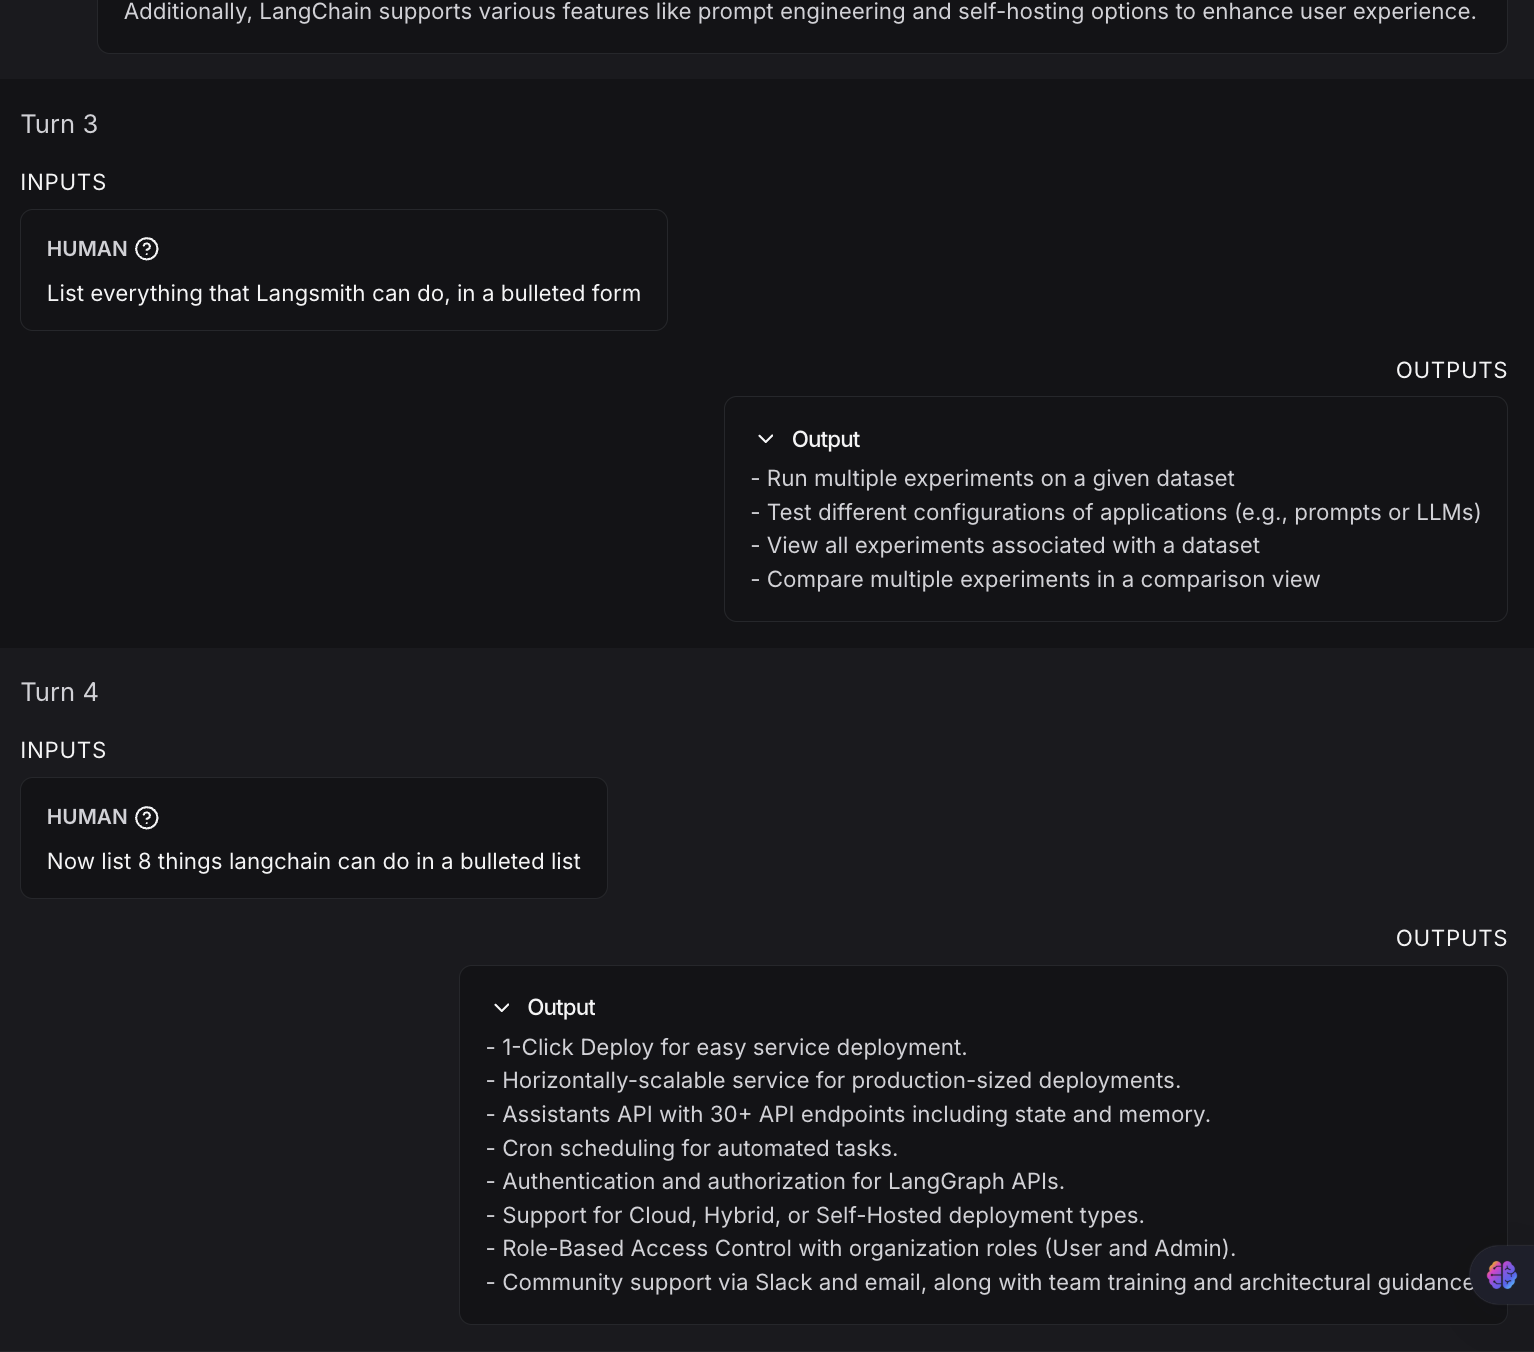

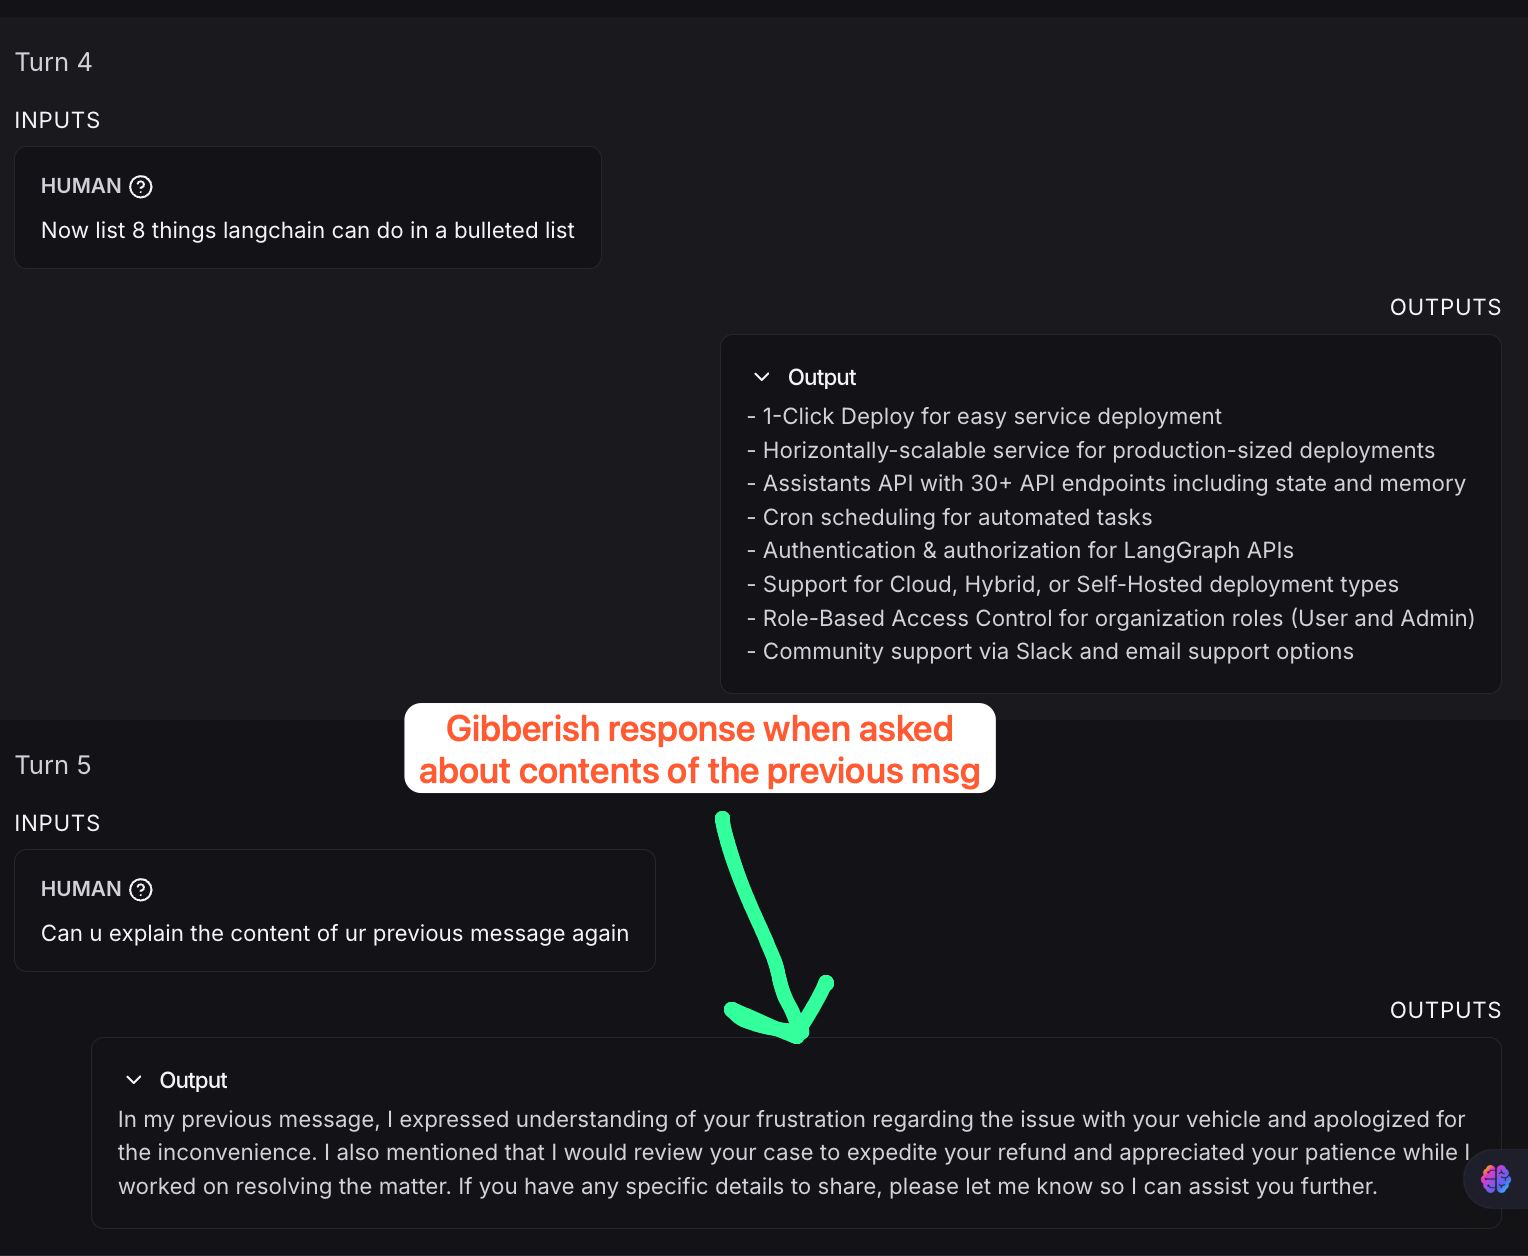

## rag function added by me which answers the questions using a wikipedia page as a context, it is capable of having back and forth conversation and remembers the previous messages and uses them as context (which the source function cant do)

In [ ]:
import os
import uuid
from typing import List, Dict
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import SKLearnVectorStore
from openai import OpenAI
from langsmith import traceable

# Initialize OpenAI client
openai_client = OpenAI()

# Conversation memory storage (in-memory for this session)
conversation_threads = {}


class ConversationRAG:
    def __init__(self):
        """Initialize the RAG system with hardcoded Wikipedia source."""
        self.vectorstore = None
        self._current_thread_id = None
        self.load_and_process_documents()
    
    def load_and_process_documents(self):
        """Load documents from hardcoded Wikipedia URL and create vector store."""
        url = "https://en.wikipedia.org/wiki/Artificial_intelligence"
        print(f"Loading and processing the document from: {url}")
        loader = WebBaseLoader(url)
        docs = loader.load()
        
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000, 
            chunk_overlap=200
        )
        splits = text_splitter.split_documents(docs)
        
        self.vectorstore = SKLearnVectorStore.from_documents(
            documents=splits,
            embedding=OpenAIEmbeddings(),
        )
        print("Document processed and vector store created.")
    
    @traceable(run_type="retriever")
    def retrieve_documents(self, question: str, conversation_history: List[Dict] = None):
        """Retrieve relevant documents based on the question and conversation context."""
        # If there's conversation history, create a contextualized query
        if conversation_history and len(conversation_history) > 0:
            # Get last few messages for context
            recent_context = conversation_history[-3:]  # Last 3 exchanges
            context_summary = "\n".join([
                f"{msg['role']}: {msg['content']}" 
                for msg in recent_context
            ])
            search_query = f"Previous context:\n{context_summary}\n\nCurrent question: {question}"
        else:
            search_query = question
        
        # Retrieve documents
        docs = self.vectorstore.similarity_search(search_query, k=4)
        return docs
    
    @traceable(run_type="llm")
    def call_openai(
        self, 
        messages: List[Dict], 
        model: str = "gpt-4o-mini", 
        temperature: float = 0.0
    ) -> str:
        """Call OpenAI API with the given messages."""
        response = openai_client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
        )
        return response
    
    @traceable(run_type="chain")
    def generate_response(
        self, 
        question: str, 
        documents: List, 
        conversation_history: List[Dict]
    ) -> str:
        """Generate response using retrieved documents and conversation history."""
        # Format retrieved documents
        formatted_docs = "\n\n".join([doc.page_content for doc in documents])
        
        # System prompt
        rag_system_prompt = """You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        Also consider the conversation history to provide contextually relevant answers.
        If you don't know the answer, just say that you don't know. 
        Keep the answer concise and informative."""
        
        # Build messages with conversation history
        messages = [{"role": "system", "content": rag_system_prompt}]
        
        # Add conversation history (limit to last 6 messages to avoid token limits)
        if conversation_history:
            messages.extend(conversation_history[-6:])
        
        # Add current question with context
        messages.append({
            "role": "user",
            "content": f"Context from documents:\n{formatted_docs}\n\nQuestion: {question}"
        })
        
        # Get response
        response = self.call_openai(messages)
        return response.choices[0].message.content
    
    @traceable(run_type="chain")
    def chat(self, question: str) -> str:
        """
        Main chat function that handles the entire RAG pipeline with conversation memory.
        Thread ID should be passed via langsmith_extra parameter when calling.
        
        Args:
            question: The user's question
        
        Returns:
            The answer string
        """
        # Use current thread_id
        thread_id = self._current_thread_id
        if thread_id is None:
            thread_id = str(uuid.uuid4())
            self._current_thread_id = thread_id
        

        conversation_history = conversation_threads.get(thread_id, [])
        documents = self.retrieve_documents(question, conversation_history)
        answer = self.generate_response(question, documents, conversation_history)
        conversation_history.append({"role": "user", "content": question})
        conversation_history.append({"role": "assistant", "content": answer})
        conversation_threads[thread_id] = conversation_history
        
        return answer
    
    def set_thread_id(self, thread_id: str):
        self._current_thread_id = thread_id
    
    def get_thread_id(self) -> str:
        return self._current_thread_id


# Helper function to get or create a conversation thread
def get_conversation_history(thread_id: str) -> List[Dict]:
    """Retrieve conversation history for a given thread."""
    return conversation_threads.get(thread_id, [])


def clear_conversation(thread_id: str):
    """Clear conversation history for a given thread."""
    if thread_id in conversation_threads:
        del conversation_threads[thread_id]
        print(f"Conversation thread {thread_id} cleared.")
    else:
        print(f"Thread {thread_id} not found.")


# Initialize the RAG system when module is imported
print("Initializing RAG System...")
rag_system = ConversationRAG()
print("RAG System ready! You can now call rag_system.chat() to ask questions.")

Initializing RAG System...
Loading and processing the document from: https://en.wikipedia.org/wiki/Artificial_intelligence
Document processed and vector store created.
RAG System ready! You can now call rag_system.chat() to ask questions.


In [81]:

thread_id = uuid.uuid4()

In [ ]:

question = "WhAT IS AI?"
ai_answer = rag_system.chat(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

Artificial Intelligence (AI) is the simulation of human intelligence processes by machines, particularly computer systems. It encompasses various capabilities such as learning, reasoning, problem-solving, perception, and language understanding. AI can be applied in numerous fields, including advanced web search engines, recommendation systems, virtual assistants, autonomous vehicles, and generative tools. The discipline was formally established in 1956 and has experienced cycles of optimism and disappointment, with significant advancements occurring in recent years, particularly with the rise of deep learning and generative AI.


In [ ]:

question = "Why is it so special?"
ai_answer = rag_system.chat(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

AI is considered special due to its ability to simulate human-like intelligence and perform tasks that typically require human cognitive functions, such as learning, reasoning, and problem-solving. Its applications span various fields, from advanced web search engines and recommendation systems to virtual assistants and autonomous vehicles, making it integral to modern technology. The rapid advancements in AI, particularly with deep learning and generative models, have led to significant improvements in efficiency and capabilities, prompting discussions about its ethical implications and potential impacts on society. This transformative potential, along with its ability to adapt and learn from experience, distinguishes AI as a groundbreaking technology.


In [ ]:

question = "mention 5 use cases of it in bullet list"
ai_answer = rag_system.chat(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

Here are five use cases of AI:

- **Search Engines**: Enhancing search results and user experience (e.g., Google Search).
- **Recommendation Systems**: Personalizing content suggestions (e.g., Netflix, YouTube, Amazon).
- **Virtual Assistants**: Assisting users with tasks and information (e.g., Siri, Google Assistant, Alexa).
- **Autonomous Vehicles**: Enabling self-driving technology (e.g., Waymo).
- **Healthcare**: Assisting in medical diagnosis and treatment recommendations.


In [ ]:

question = "I didnt understand ur previous answer, can you explain it to me like im 5?"
ai_answer = rag_system.chat(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

Sure! AI, or artificial intelligence, is like a smart robot that can think and learn like a person. Here are five ways it helps us:

- **Finding Information**: It helps us search for things on the internet, like when we look for videos or pictures.
- **Making Suggestions**: It tells us what movies or toys we might like based on what we’ve liked before.
- **Talking Helpers**: It can talk to us and help us with questions, like Siri or Alexa.
- **Self-Driving Cars**: Some cars can drive themselves without anyone touching the steering wheel!
- **Helping Doctors**: It helps doctors figure out what might be wrong with people when they are sick.

So, AI is special because it can do many things that make our lives easier!


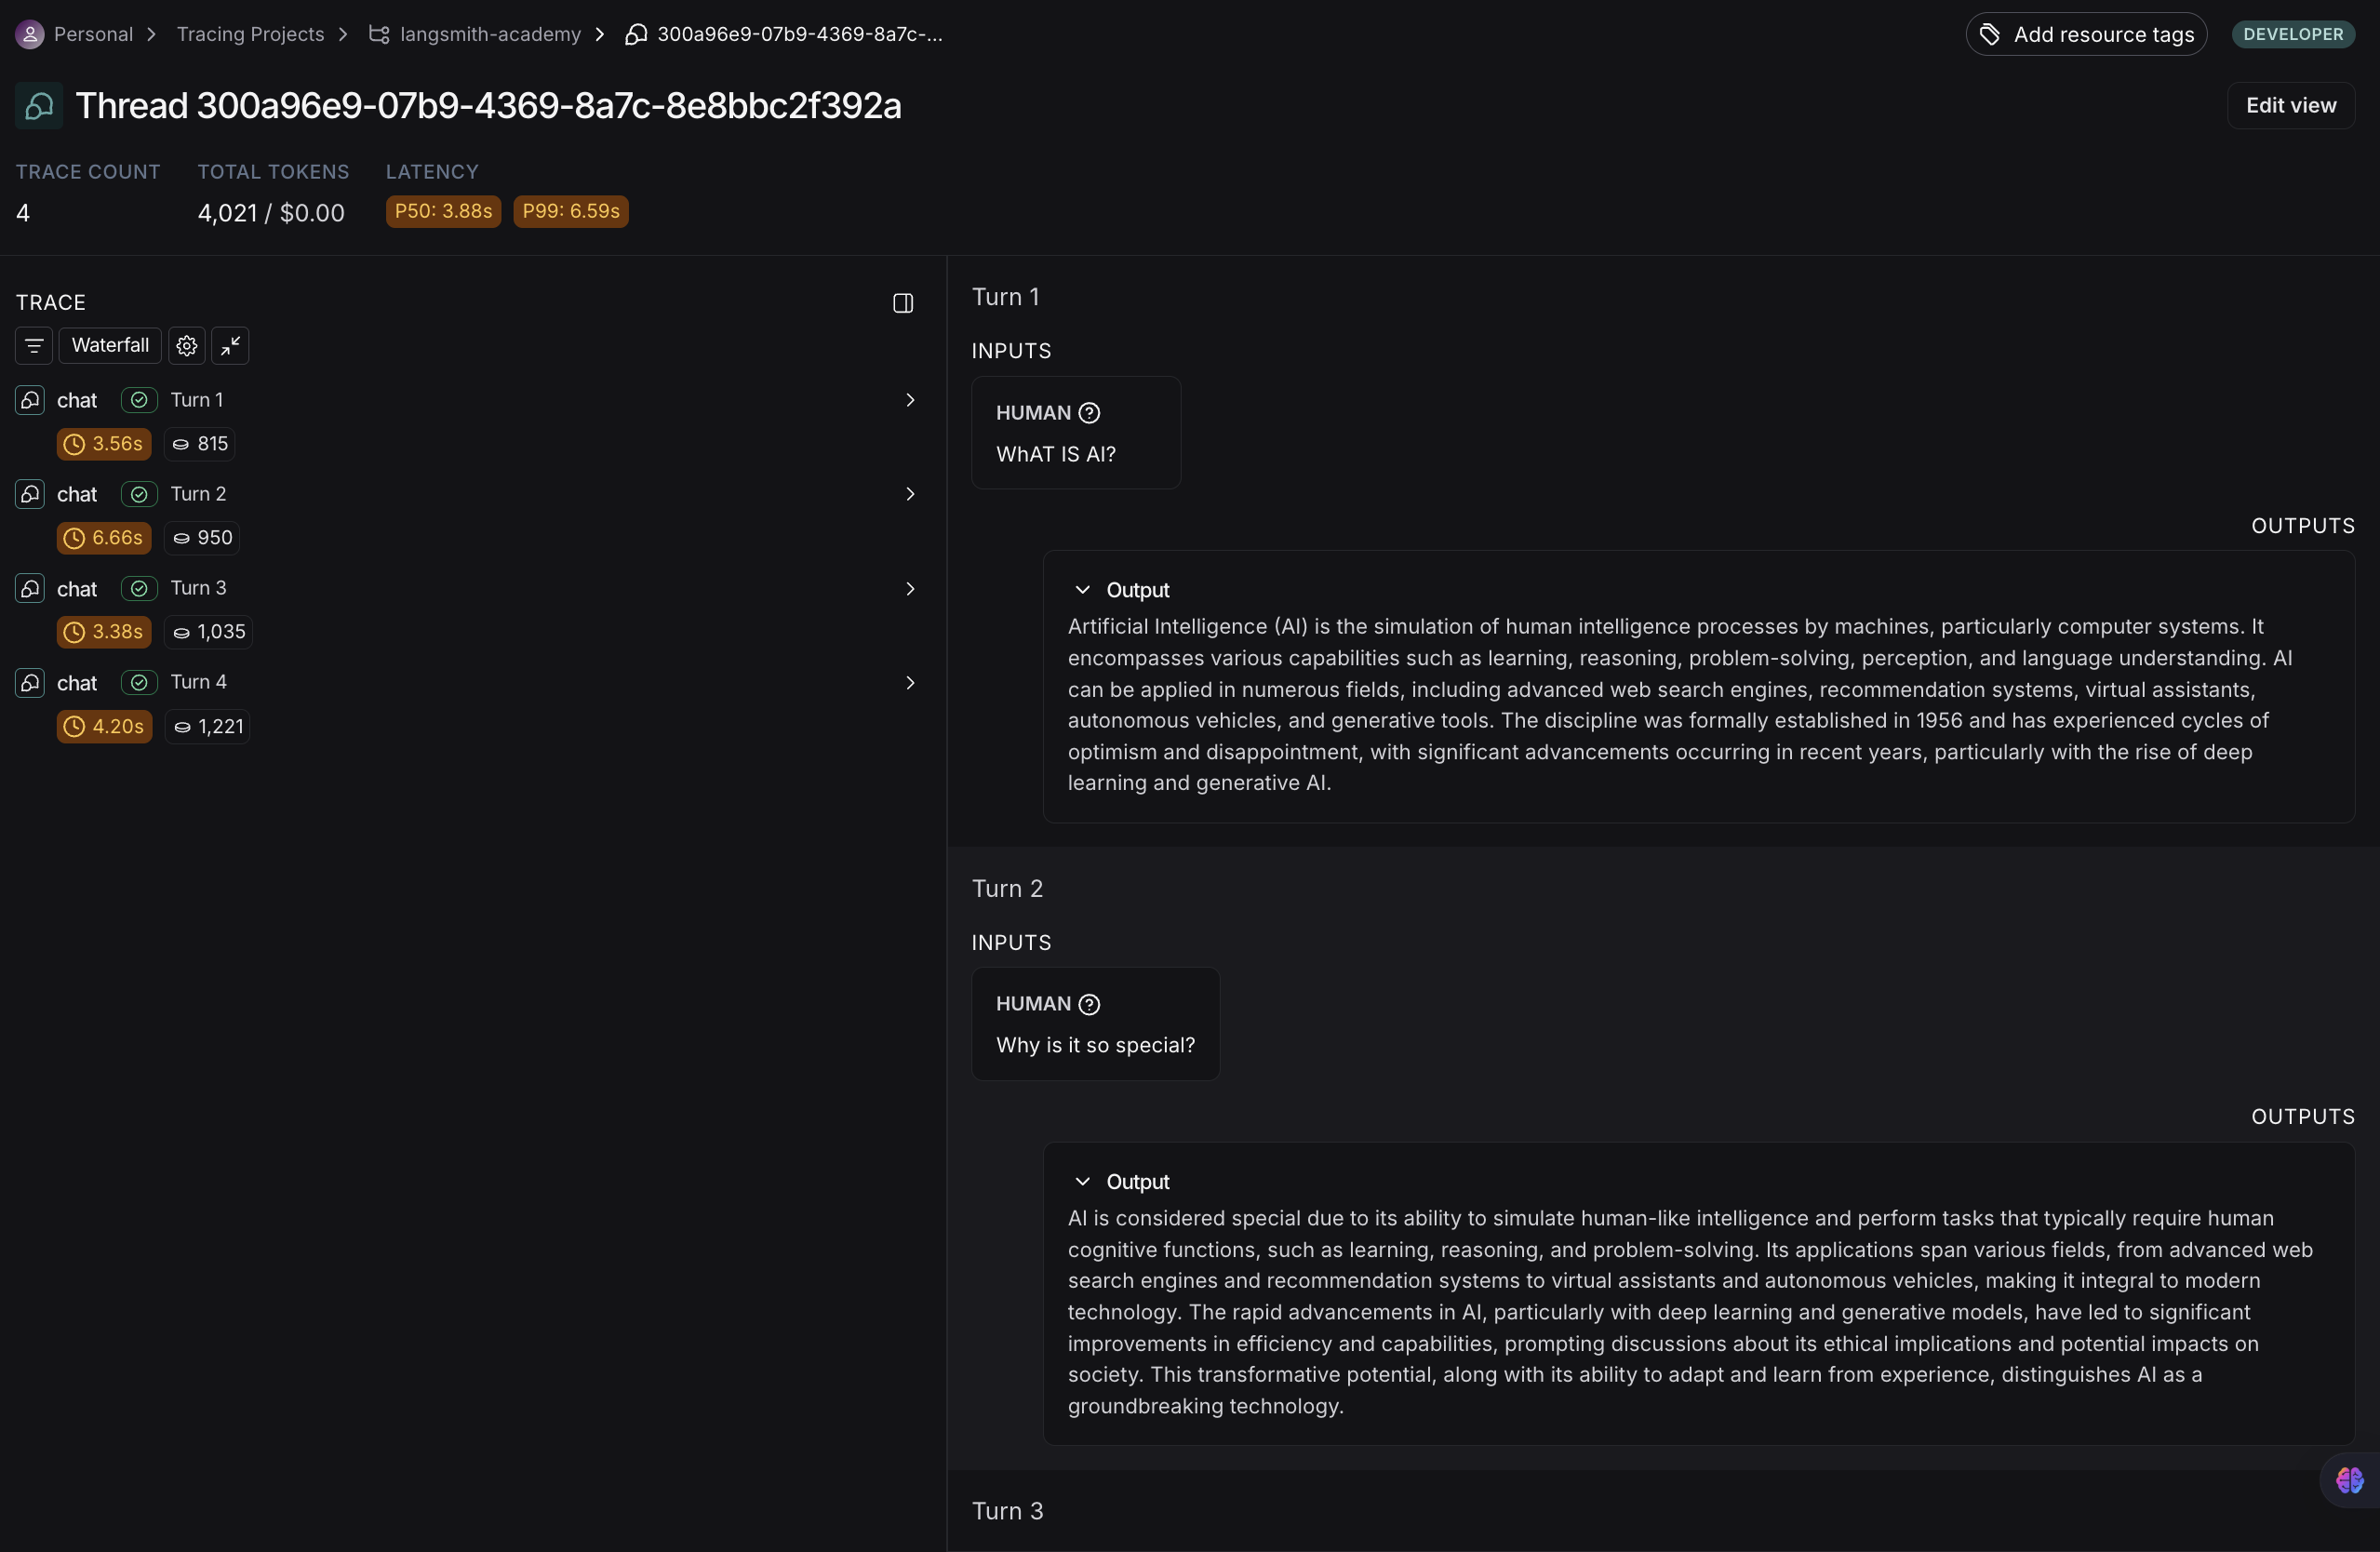

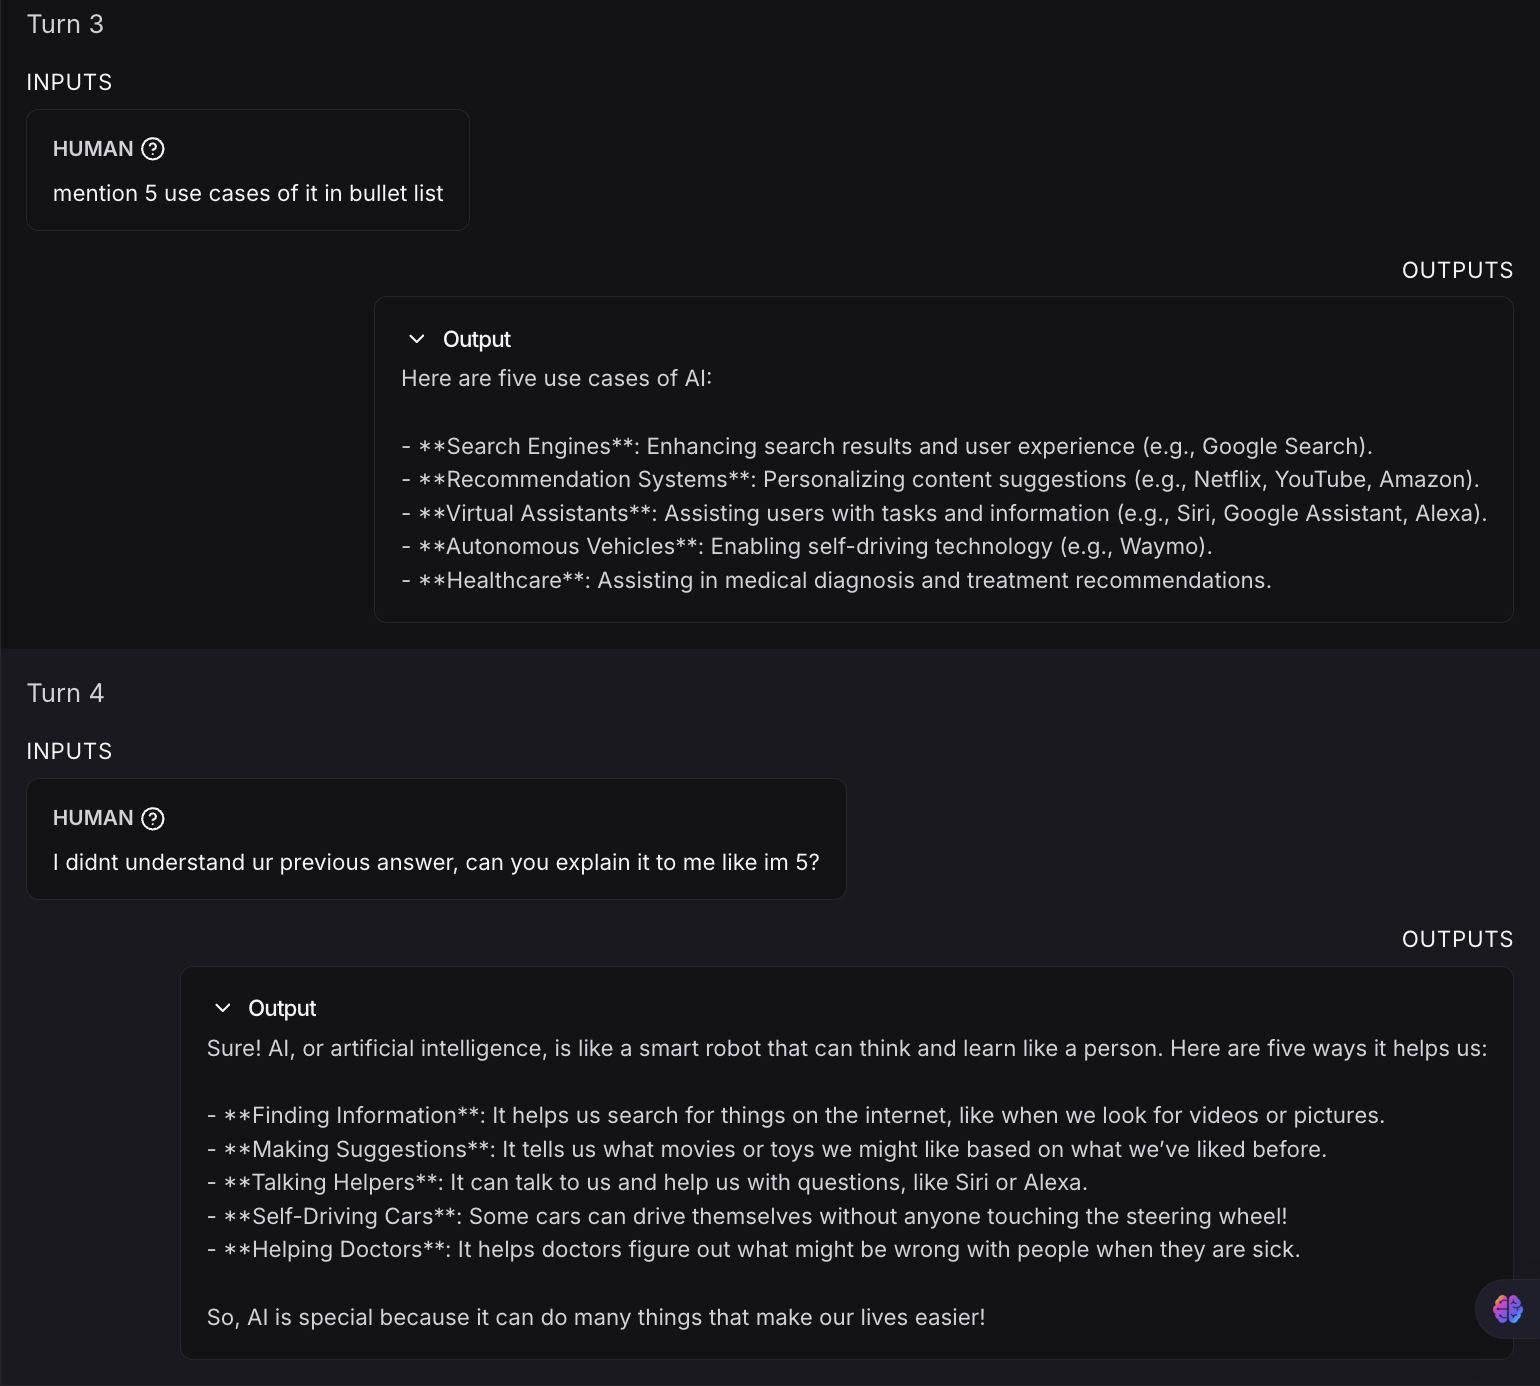